# Making Gaussian Simulations with `healpy` 

Author: Tanveer Karim

By the end of this tutorial, you will learn how to use `healpy` to produce Gaussian Simulations. I assume that you are familiar with 3D power spectrum, $P(k)$ generator codebase `camb` or `CLASS`. I also assume that you have your own code that can generate projected (angular) power spectrum, $C (\ell)$, of your desired tracer. 

In [1]:
%matplotlib inline

from matplotlib import pyplot as plt
import numpy as np

import camb
from camb import model, initialpower

import healpy as hp

plt.style.use("ggplot")

For demonstration purposes, I am using `camb` to produce CMB temperature-temperature power spectrum, $C_{\rm TT} (\ell)$. But you should use your own code to produce $C(\ell)$ for your desired tracer. 

In [17]:
# run camb to get projected power spectrum C_ell
pars =  camb.set_params(H0=67.5, ombh2=0.022, omch2=0.122, ns=0.965)
results = camb.get_results(pars)

# As an example, C_TT power spectrum
powers =results.get_cmb_power_spectra(pars, CMB_unit='muK')

# the total temperature-temperature power spectrum
cl_TT_tot = powers['total'][:,0]

Let's plot the total $C_{\rm TT}$ power spectrum to see how it looks like. 

Text(0, 0.5, '$C_{\\rm TT} (\\ell)$')

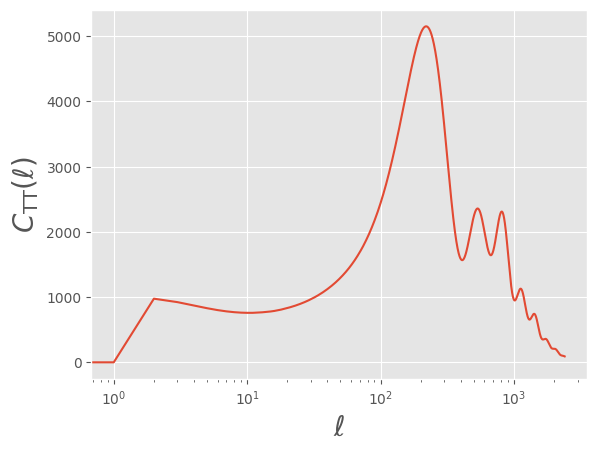

In [6]:
ells = np.arange(len(cl_TT_tot)) # ell ranging from 0 to the max camb produces

plt.semilogx(ells, cl_TT_tot)
plt.xlabel(r"$\ell$", fontsize = 20)
plt.ylabel(r"$C_{\rm TT} (\ell)$", fontsize = 20)

## Mapmaking from theory $C (\ell)$ 

In this section we will now go over how to generate realizations of maps using theoretical power spectra. This is where the package `healpy` will become helpful.

`healpy` is a very popular package used in projected power spectra analysis, built on the codebase `HEALPix`. 

Remember that $C(\ell)$ describes the *variance* of overdensity at every scale, when the mean is equal to $0$. If you are wondering how do we know that the mean is $0$, keep in mind that we can always subtract off the mean to make the transformed map's mean equal to $0$. The variance of an overdensity map, or a scalar field, is not affected by this kind of transformation. If you are not convinced, it is a good exercise to over!

With this in mind, let's consider what `healpy` does with the $C (\ell)$ values. Since we know the mean is $0$, and we know what the variance is at every scale, we can use some Gaussian random number generator to sample a value with those mean and variance. And if we do this at every scale and add those realizations together, then we have a map realization. 

This is exactly what `healpy.synfast` does. The mandatory arguments we set are `cls = power`, `nside = NSIDE`, `pol = False`. Let's understand what these arguments mean.

- `cls` : This is the power spectrum you pass. `synfast` can take more than one set of `cls` but we will revisit this idea in the next section.

- `nside` : This is where the magic of `HEALPix` takes place. `HEALPix` uses a base pixelization scheme of 12 pixels. What this means is that the software breaks up the entire sky into 12 chunks of equal areas. This is the coarsest resolution we have. This is `nside = 1`. If you go to `nside = 2`, it divides up the base resolution equally into four smaller chunks. If you then consider `nside = 3`, it divides up pixels of size `nside = 2` into four smaller chunks. And this process takes place iteratively. In general, the number of pixels with a resolution of `NSIDE` is equal to $N_{\rm pix} = 12 \times {\rm NSIDE}^2$. For now, we will set `NSIDE = 1024`, which means each of the 12 base pixels is broken up into $1024^2$ chunks.

- `pol` : boolean argument about whether our map is polarized or not. Overdensity fields like galaxies, lensing are not polarized so we set this to `False`. If you are using a polarized field, you can look at the `healpy` documentation for more details. 

In [9]:
# pass power spectrum to synfast
NSIDE = 1024

map_realization = hp.synfast(cls = cl_TT_tot, nside = NSIDE, pol=False)

`healpy` provides nice visualization tooks to take a look at the map we just created.

You can optionally set arguments such as the `min` and `max` of the map, the color scheme, `cmap`, and a map `title`. 

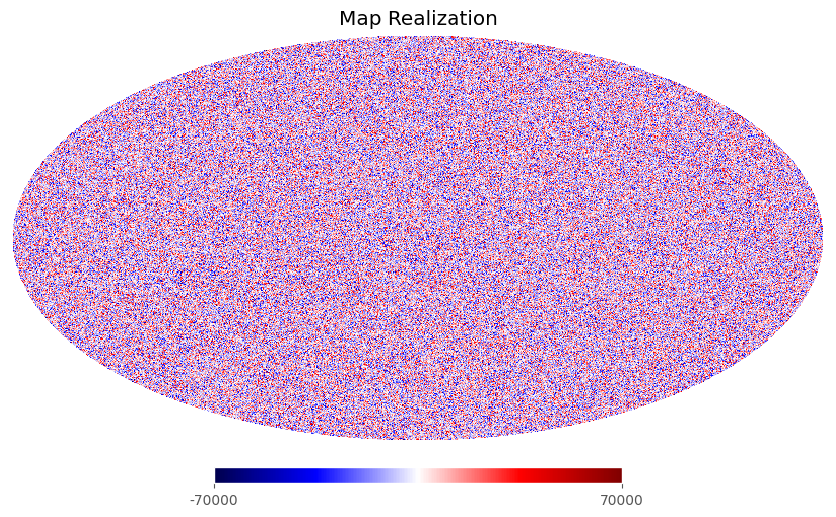

In [10]:
hp.mollview(map_realization, min = - 70000, max = + 70000,
            cmap = 'seismic', title = 'Map Realization')

Thus, you have your first simulation! 

But how do I know this map indeed has the power spectrum that I used as the input for `synfast`? 

We can use another `healpy` function called `anafast` that takes in any map, and can decompose it into the projected power spectrum using spherical harmonics transform.

In [11]:
cl_TT_tot_measured = hp.anafast(map_realization, pol = False)

Now, let's plot the measured $C(\ell)$ with the original input. 

Note, that very low $\ell$ values may look pathological due to cosmic variance and there are other algorithms such as Fast-Fourier Transform that we can use to measure those scales. So for now, we will set the largest scale (or lowest $\ell$) to be $\ell_{\rm min} = 50$. 

Similarly, we will set $\ell_{\rm max} = 2000$ because by design, `HEALPix` measures power spectra upto $3 \times {\rm NSIDE} - 1$. But since our input power spectra is smaller than that, for apples-to-apples comparison, we restrict ourselves. 

Text(0, 0.5, '$C_{\\rm TT} (\\ell)$')

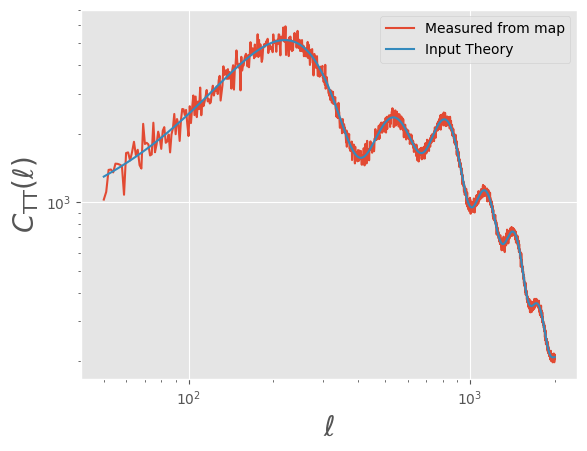

In [23]:
LMIN = 50
LMAX = 2000
plt.loglog(ells[LMIN:LMAX],
           cl_TT_tot_measured[LMIN:LMAX],
           label = 'Measured from map')
plt.loglog(ells[LMIN:LMAX], cl_TT_tot[LMIN:LMAX],
           label = 'Input Theory')
plt.legend(loc='best')
plt.xlabel(r"$\ell$", fontsize = 20)
plt.ylabel(r"$C_{\rm TT} (\ell)$", fontsize=20)

## Advanced: Correlated Mapmaking

Now think about a situation where you need to make multiple maps based on the some sets of power spectra. Where could this happen? Suppose we are considering both galaxy clustering and CMB lensing. We think that the underlying matter power spectra contributes to the creation of both of these fields. But if we generate two independent sets of simulations solely using galaxy clustering input, $C_{\rm gg} (\ell)$ and the CMB lensing convergence, $C_{\kappa kappa} (\ell)$, then you will find their cross-correlation is equal to $0$. (Can you think why this is the case)?

So, we need a way to let our simulator function `synfast` know that these power spectra should be correlated. To make things simple, we will use another package `pyccl` that will generate a set of power spectra quickly for us. 

Don't worry about the specifics of the `pyccl` arguments for now if they do not make sense. 

In [29]:
# use pyccl to generate galaxy clustering and CMB lensing power spectra

import pyccl as ccl

# Cosmology
cosmo = ccl.Cosmology(Omega_c=0.27, Omega_b=0.045, h=0.67, A_s=2.1e-9, n_s=0.96)

# Redshift-dependent functions
z = np.linspace(0,1.2,10)

# Redshift distributions
nz = np.exp(-((z-0.5)/0.05)**2/2)

# Bias
bz = 0.95*np.ones_like(z)

# galaxy tracer
galaxy = ccl.NumberCountsTracer(cosmo, 
                                has_rsd=False, dndz=(z,nz), 
                                bias=(z,bz), mag_bias=None)

# CMB lensing tracer
cmbl = ccl.CMBLensingTracer(cosmo, z_source=1100.)

# theory C_ells from pyccl
cl_gg_th = ccl.angular_cl(cosmo, galaxy, galaxy, ells)
cl_kk_th = ccl.angular_cl(cosmo, cmbl, cmbl, ells)
cl_kg_th = ccl.angular_cl(cosmo, cmbl, galaxy, ells)

The last three lines are the most important. Essentially, we produced theory power spectra for galaxy-galaxy clustering, lensing-lensing clustering, and lensing-galaxy clustering. This last power spectra is critical in helping synfast mix the maps and produce correlated simulations. 

We use a very similar syntax as before, except this time we pass a list of $3$ sets of $C(ell)$ values to `synfast`, and it produces two maps. This is highly flexible and you can extend this idea to any number of correlated maps. You just have to make sure that you have: (i) all the auto-correlation of each field, and (ii) all the cross-correlation of one field with another. 

In [30]:
sim_galaxy, sim_lensing = hp.synfast(cls = [cl_gg_th, cl_kg_th, cl_kk_th], 
                                     nside = NSIDE, pol=False)

Now let's take a look at these maps. 

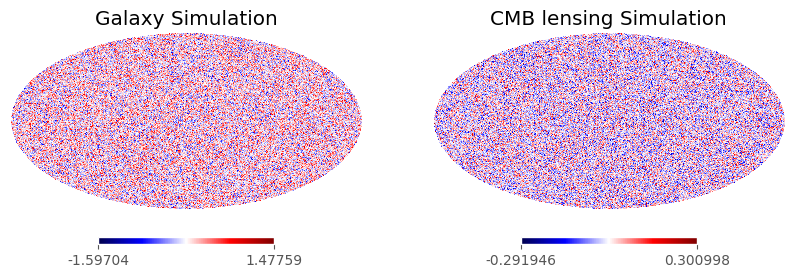

In [32]:
fig, (ax1, ax2) = plt.subplots(figsize = (10,7), ncols=2)

plt.axes(ax1)
hp.mollview(sim_galaxy, hold=True, cmap='seismic',
            title = 'Galaxy Simulation')

plt.axes(ax2)
hp.mollview(sim_lensing, hold=True, cmap = 'seismic',
            title = 'CMB lensing Simulation')

As before, let's check to make sure our realizations match inputs!

In [33]:
cl_gg_measured = hp.anafast(sim_galaxy, pol = False)
cl_kk_measured = hp.anafast(sim_lensing, pol = False)
cl_kg_measured = hp.anafast(sim_lensing, sim_galaxy, pol = False)

Note, that we can measure the cross-correlation by passing two maps to `anafast`. 

Text(0, 0.5, '$C (\\ell)$')

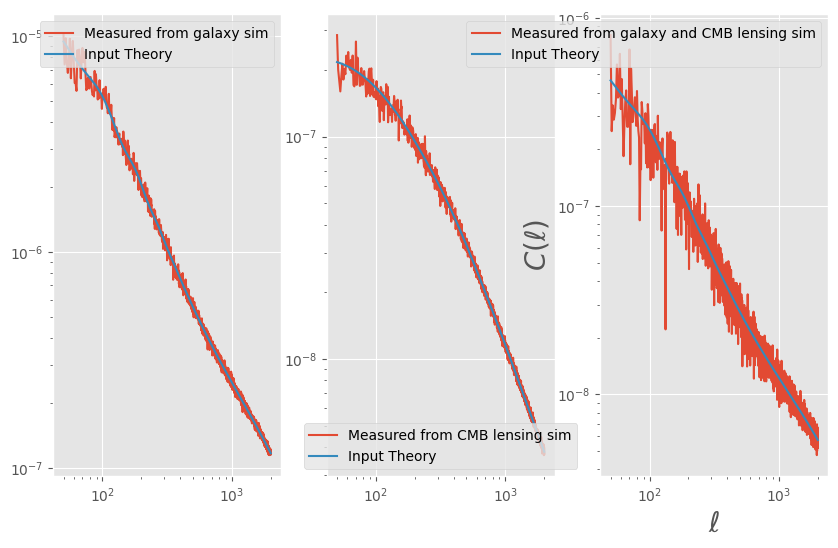

In [43]:
fig, (ax1, ax2, ax3) = plt.subplots(figsize = (10,6), ncols=3)

ax1.loglog(ells[LMIN:LMAX],
           cl_gg_measured[LMIN:LMAX],
           label = 'Measured from galaxy sim')
ax1.loglog(ells[LMIN:LMAX], cl_gg_th[LMIN:LMAX],
           label = 'Input Theory')

ax2.loglog(ells[LMIN:LMAX],
           cl_kk_measured[LMIN:LMAX],
           label = 'Measured from CMB lensing sim')
ax2.loglog(ells[LMIN:LMAX], cl_kk_th[LMIN:LMAX],
           label = 'Input Theory')

ax3.loglog(ells[LMIN:LMAX],
           cl_kg_measured[LMIN:LMAX],
           label = 'Measured from galaxy and CMB lensing sim')
ax3.loglog(ells[LMIN:LMAX], cl_kg_th[LMIN:LMAX],
           label = 'Input Theory')

# plot legends
ax1.legend(loc='best')
ax2.legend(loc='lower center')
ax3.legend(loc='best')

# labels
plt.xlabel(r"$\ell$", fontsize = 20)
plt.ylabel(r"$C (\ell)$", fontsize=20)